In [66]:
import pandas as pd
import joblib
import json
from functools import partial

from service.app_api.features.extractor import FeatureExtractor
from service.app_api.features.final_processing import CustomColumnTransformer
from service.app_api.configs import utils
from tuning.optuna_tuning import OptunaTuner
import optuna
import wandb

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
# Base classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
# Meta classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [2]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [3]:
fe = FeatureExtractor(target_month=3, n_purchases=2, perform_split=True, generation_type='continuous', filtering_set='customers', period=60, subperiod=15)
X_train, X_test, y_train, y_test = fe.transform(sales=sales, customers=customers)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.
['fuel_qty', 'labour_cards_catalogue_consumables_qty', 'peak_hours_qty', 'usual_hours_qty', 'weekday_qty', 'weekend_qty', 'unleaded_95_qty', 'last_purchase_qty_share']


In [49]:
y_train.to_csv('y_train_2_purchases.csv', index=False)
y_test.to_csv('y_test_2_purchases.csv', index=False)

In [4]:
qty_cols = [col for col in X_train.columns if 'qty' in col]
col_transform = CustomColumnTransformer(
    cols_for_scaling=qty_cols,
    scaling_algo=RobustScaler(),
    cols_for_ohe=None,
    cols_for_winsor=None,
    cols_to_skip=[col for col in X_train.columns if 'qty' in col]
)

In [5]:
X_train_trans = col_transform.fit_transform(X_train)
X_test_trans = col_transform.fit_transform(X_test)

In [4]:
f1_score_average_weighted = partial(f1_score, average='weighted')

In [5]:
def params_to_txt(optuna_object):
    model = optuna_object.model
    model_name = model.__str__()[:model.__str__().find('(')]
    best_params = model.get_params()
    with open(f'{model_name}.txt', 'w') as f:
        f.write(json.dumps(best_params, indent=4))

In [21]:
def load_params(model):
    try:
        model = model()
    except TypeError:
        pass
    model_name = model.__str__()[:model.__str__().find('(')]
    with open(f'{model_name}.txt', 'r') as f:
        params = json.loads(f.read())
    return params

## SVC base model

In [8]:
# svc_op = OptunaTuner(
#     SVC,
#     accuracy_score,
#     direction='maximize',
#     random_state=571,
#     verbose=False,
#     tol=1
# )
# svc_op.fit(
#     50, X_train_trans, y_train, X_test_trans, y_test,
#     ('C', 'float', 1e-3, 1.0),
#     ('kernel', 'categorical', ['linear', 'poly', 'rbf', 'sigmoid']),
#     ('degree', 'int', 1, 15)
# )

In [9]:
# optuna.visualization.plot_optimization_history(svc_op.study)

In [10]:
# svc_op.model.get_params()

In [36]:
svc_best = SVC(
    verbose=False,
    random_state=571,
    tol=1,
    probability=True
)
svc_best.fit(X_train, y_train)
svc_train_preds = svc_best.predict(X_train)
svc_test_preds = svc_best.predict(X_test)

In [37]:
print('Train:')
print(classification_report(y_train, svc_train_preds), '\n')
print('Test:')
print(classification_report(y_test, svc_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85     14415
           1       0.77      0.58      0.66      7882

    accuracy                           0.79     22297
   macro avg       0.78      0.74      0.75     22297
weighted avg       0.79      0.79      0.78     22297
 

Test:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      4744
           1       0.76      0.57      0.65      2689

    accuracy                           0.78      7433
   macro avg       0.77      0.74      0.75      7433
weighted avg       0.78      0.78      0.77      7433



## KNN base model

In [13]:
knn_op = OptunaTuner(
    KNeighborsClassifier,
    f1_score_average_weighted,
    direction='maximize',
    n_jobs=7
)
knn_op.fit(
    100, X_train, y_train, X_test, y_test,
    ('n_neighbors', 'int', 1, 50)
)

In [14]:
optuna.visualization.plot_optimization_history(knn_op.study)

In [26]:
try:
    knn_best_params = load_params(KNeighborsClassifier)
    knn_best = KNeighborsClassifier(**knn_best_params)
except FileNotFoundError:
    knn_best = KNeighborsClassifier(**knn_op.model.get_params())
knn_best.fit(X_train, y_train)
knn_train_preds = knn_best.predict(X_train)
knn_test_preds = knn_best.predict(X_test)

In [16]:
print('Train:')
print(classification_report(y_train, knn_train_preds), '\n')
print('Test:')
print(classification_report(y_test, knn_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85     14415
           1       0.75      0.62      0.68      7882

    accuracy                           0.79     22297
   macro avg       0.78      0.75      0.76     22297
weighted avg       0.79      0.79      0.79     22297
 

Test:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4744
           1       0.75      0.61      0.67      2689

    accuracy                           0.79      7433
   macro avg       0.77      0.75      0.76      7433
weighted avg       0.78      0.79      0.78      7433



In [17]:
params_to_txt(knn_op)

## Random Forest base model

In [18]:
# api = wandb.Api()
# run = api.run(f"{settings.SETTINGS['WANDB_ENTITY']}/Random-Forest-Classifier/qzbhynm9")

In [19]:
# rf_config = json.loads(run.json_config)
# rf_params = {}
# for param in rf_config:
#     rf_params.update({param: rf_config[param]['value']})

In [20]:
rf_op = OptunaTuner(RandomForestClassifier, f1_score_average_weighted, direction='maximize', random_state=571, n_jobs=7)
rf_op.fit(
    300, X_train, y_train, X_test, y_test,
    ('n_estimators', 'int', 10, 200),
    ('max_depth', 'int', 30, 60),
    ('max_features', 'float', 0.05, 1.0, {'step': 0.05}),
    ('max_samples', 'float', 0.05, 1.0, {'step': 0.05}),
    ('min_samples_leaf', 'float', 1e-4, 1e-2, {'log': True}),
    ('min_samples_split', 'float', 1e-4, 1e-2, {'log': True})
)

In [27]:
try:
    rf_best_params = load_params(RandomForestClassifier)
    rf_best = RandomForestClassifier(**rf_best_params)
except FileNotFoundError:
    rf_best = RandomForestClassifier(**rf_op.model.get_params())
rf_best.fit(X_train, y_train)
rf_train_preds = rf_best.predict(X_train)
rf_test_preds = rf_best.predict(X_test)

In [23]:
print('Train:')
print(classification_report(y_train, rf_train_preds), '\n')
print('Test:')
print(classification_report(y_test, rf_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     14415
           1       0.80      0.71      0.75      7882

    accuracy                           0.84     22297
   macro avg       0.83      0.81      0.82     22297
weighted avg       0.83      0.84      0.83     22297
 

Test:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4744
           1       0.77      0.67      0.71      2689

    accuracy                           0.81      7433
   macro avg       0.80      0.78      0.78      7433
weighted avg       0.80      0.81      0.80      7433



In [24]:
params_to_txt(rf_op)

## XGBoost base model

In [43]:
xgb_op = OptunaTuner(
    XGBClassifier, f1_score_average_weighted, 'maximize', # class-specific arguments
    seed=571, predictor='cpu_predictor', verbosity=0, nthread=7, # model-specific technical parameters
    objective='binary:hinge', eval_metric='error', n_estimators=1000 # model-specific fixed hyperparameters
)
xgb_op.fit(
    300, X_train, y_train, X_test, y_test,
    ('reg_alpha', 'loguniform', 1e-3, 10.0),
    ('reg_lambda', 'loguniform', 1e-3, 10.0),
    ('colsample_bytree', 'loguniform', 0.2, 1.0),
    ('subsample', 'loguniform', 0.4, 1.0),
    ('learning_rate', 'loguniform', 1e-4, 0.5),
    ('max_depth', 'categorical', [5, 10, 20, 30])
)

In [28]:
try:
    xgb_best_params = load_params(XGBClassifier)
    xgb_best = XGBClassifier(**xgb_best_params)
except FileNotFoundError:
    xgb_best = XGBClassifier(**xgb_op.model.get_params())
xgb_best.fit(X_train, y_train)
xgb_train_preds = xgb_best.predict(X_train)
xgb_test_preds = xgb_best.predict(X_test)

In [46]:
print('Train:')
print(classification_report(y_train, xgb_train_preds), '\n')
print('Test:')
print(classification_report(y_test, xgb_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     14415
           1       0.83      0.76      0.79      7882

    accuracy                           0.86     22297
   macro avg       0.85      0.84      0.84     22297
weighted avg       0.86      0.86      0.86     22297
 

Test:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4744
           1       0.75      0.70      0.72      2689

    accuracy                           0.80      7433
   macro avg       0.79      0.78      0.79      7433
weighted avg       0.80      0.80      0.80      7433



In [48]:
params_to_txt(xgb_op)

In [ ]:
cm = confusion_matrix(y_test, xgb_test_preds)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=xgb_best.classes_)

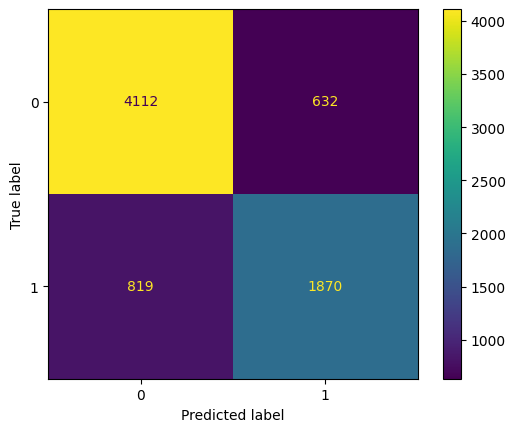

In [53]:
cm_disp.plot()

In [ ]:
config = xgb_op.model.get_params()

# Create w&b run for the training set
with utils.init_wandb_run(
    name='continuous_features_subperiod_15_customers_filtering_2_purchases',
    model=XGBClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_train'
) as run:

    rep = utils.parse_classification_report(
        classification_report(y_train, xgb_train_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name,
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_train',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

# Create w&b run for the test set
with utils.init_wandb_run(
    name='continuous_features_subperiod_15_customers_filtering_2_purchases',
    model=XGBClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_test'
) as run:
    rep = utils.parse_classification_report(
        classification_report(y_test, xgb_test_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_test',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

## Identify overlaps of models errors

In [30]:
base_models_df = pd.DataFrame(
    {
        'svc_preds': svc_test_preds,
        'knn_preds': knn_test_preds,
        'rf_preds': rf_test_preds,
        'xgb_preds': xgb_test_preds,
        'y_true': y_test
    }
)

In [31]:
base_models_df['svc_accuracy'] = base_models_df.apply(lambda x: 'error' if x['svc_preds'] != x['y_true'] else 'correct', axis=1)
base_models_df['knn_accuracy'] = base_models_df.apply(lambda x: 'error' if x['knn_preds'] != x['y_true'] else 'correct', axis=1)
base_models_df['rf_accuracy'] = base_models_df.apply(lambda x: 'error' if x['rf_preds'] != x['y_true'] else 'correct', axis=1)
base_models_df['xgb_accuracy'] = base_models_df.apply(lambda x: 'error' if x['xgb_preds'] != x['y_true'] else 'correct', axis=1)

In [32]:
svc_errors = base_models_df[base_models_df['svc_accuracy']=='error'].index
knn_errors = base_models_df[base_models_df['knn_accuracy']=='error'].index
rf_errors = base_models_df[base_models_df['rf_accuracy']=='error'].index
xgb_errors = base_models_df[base_models_df['xgb_accuracy']=='error'].index

In [33]:
# Overlap of all models
len(
    set.intersection(
        set(svc_errors),
        set(knn_errors),
        set(rf_errors),
        set(xgb_errors)
    )
) / base_models_df.shape[0]

0.1442217139782053

In [39]:
len(
    set.intersection(
        set(rf_errors),
        set(xgb_errors)
    )
) / base_models_df.shape[0]

0.18269877572985335

## Models Stacking

In [40]:
stacking_model = StackingClassifier(
    estimators=[
        ('svc', svc_best),
        ('knn', knn_best),
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [41]:
stacking_model.fit(X_train, y_train)
stacking_train_preds = stacking_model.predict(X_train)
stacking_test_preds = stacking_model.predict(X_test)

In [42]:
print('Train:')
print(classification_report(y_train, stacking_train_preds), '\n')
print('Test:')
print(classification_report(y_test, stacking_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     14415
           1       0.81      0.70      0.75      7882

    accuracy                           0.84     22297
   macro avg       0.83      0.81      0.81     22297
weighted avg       0.83      0.84      0.83     22297
 

Test:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4744
           1       0.77      0.66      0.71      2689

    accuracy                           0.81      7433
   macro avg       0.80      0.77      0.78      7433
weighted avg       0.80      0.81      0.80      7433



## Voting Stacking

In [63]:
voting_stacking_model = VotingClassifier(
    estimators=[
        ('svc', svc_best),
        ('knn', knn_best),
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='soft',
    n_jobs=7
)

In [64]:
voting_stacking_model.fit(X_train, y_train)
voting_stacking_train_preds = voting_stacking_model.predict(X_train)
voting_stacking_test_preds = voting_stacking_model.predict(X_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [65]:
print('Train:')
print(classification_report(y_train, voting_stacking_train_preds), '\n')
print('Test:')
print(classification_report(y_test, voting_stacking_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14415
           1       0.82      0.75      0.79      7882

    accuracy                           0.86     22297
   macro avg       0.85      0.83      0.84     22297
weighted avg       0.85      0.86      0.85     22297
 

Test:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4744
           1       0.75      0.69      0.72      2689

    accuracy                           0.80      7433
   macro avg       0.79      0.78      0.78      7433
weighted avg       0.80      0.80      0.80      7433



In [67]:
params = {
    'weights': [
        (1, 1, 3, 3),
        (1, 1, 2, 3),
        (1, 1, 3, 4),
        (1, 1, 2, 5),
        (1, 2, 2, 3),
        (1, 2, 3, 4),
        (1, 2, 3, 3)
    ]
}
grid = GridSearchCV(
    estimator=voting_stacking_model,
    param_grid=params,
    n_jobs=7,
    cv=5,
    scoring=make_scorer(f1_score, **{'average': 'weighted'})
)

In [68]:
grid.fit(X_train, y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('svc',
                                                     SVC(probability=True,
                                                         random_state=571,
                                                         tol=1)),
                                                    ('knn',
                                                     KNeighborsClassifier(n_jobs=7,
                                                                          n_neighbors=33)),
                                                    ('rf',
                                                     RandomForestClassifier(max_depth=53,
                                                                            max_features=0.8500000000000001,
                                                                            max_samples=0.7000000000000001,
                                                                            min_samples_leaf=0.0007811550408734325,
                                                                            min_samples_split=0.00012081964294076039,
                                                                            n...
                                                                   max_delta_step=0,
                                                                   max_depth=20,
                                                                   max_leaves=0,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints='()',
                                                                   n_estimators=1000,
                                                                   n_jobs=7,
                                                                   nthread=7,
                                                                   num_parallel_tree=1,
                                                                   objective='binary:hinge', ...))],
                                        n_jobs=7, voting='soft'),
             n_jobs=7,
             param_grid={'weights': [(1, 1, 3, 3), (1, 1, 2, 3), (1, 1, 3, 4),
                                     (1, 1, 2, 5), (1, 2, 2, 3), (1, 2, 3, 4),
                                     (1, 2, 3, 3)]},
             scoring=make_scorer(f1_score, average=weighted))

In [69]:
tuned_voting_stacking_train_preds = grid.predict(X_train)
tuned_voting_stacking_test_preds = grid.predict(X_test)

In [71]:
print('Train:')
print(classification_report(y_train, tuned_voting_stacking_train_preds), '\n')
print('Test:')
print(classification_report(y_test, tuned_voting_stacking_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     14415
           1       0.83      0.76      0.79      7882

    accuracy                           0.86     22297
   macro avg       0.85      0.84      0.84     22297
weighted avg       0.86      0.86      0.86     22297
 

Test:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4744
           1       0.75      0.70      0.72      2689

    accuracy                           0.80      7433
   macro avg       0.79      0.78      0.79      7433
weighted avg       0.80      0.80      0.80      7433

